In [26]:
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, Input, Reshape, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import pandas as pd

sr = 44100

# gan에 입력되는 noise에 대한 dimension
NOISE_DIM = 10 #잘 모르겠음...ㅎㅎ

# adam optimizer 정의, learning_rate = 0.0002, beta_1로 줍니다.
# Vanilla Gan과 DCGAN에서 이렇게 셋팅을 해주는데
# 이렇게 해줘야 훨씬 학습을 잘합니다.
# 그렇다고 합니다..ㅎㅎ
adam = Adam(lr=0.0002, beta_1=0.5)
mfcc_data = []

In [7]:
def load_wave_generator(path): #이전 깃헙에서 가져온 파일 읽어들이는 함수(라벨 붙이는것만 삭제)

    batch_waves = []
    stft_data = []
    temp = []
    global s_data

    folders = os.listdir(path)

    for folder in folders:
        if not os.path.isdir(path):continue #폴더가 아니면 continue
        files = os.listdir(path+"/"+folder)
        print("Foldername :",folder,"-",len(files),"files")
        #폴더 이름과 그 폴더에 속하는 파일 갯수 출력
        for wav in files:
            if not wav.endswith(".wav"):continue
            else:
                #print("Filename :",wav)#.wav 파일이 아니면 continue
                y, sr = librosa.load(path+"/"+folder+"/"+wav)
                ny = y[:sr*5]
                stft = librosa.stft(ny, n_fft=128, hop_length=64, win_length=128).T
                stft = np.abs(stft)
                
                stft_data.append(stft)
                #print("Stft Size : ", stft.shape)
                
    #end loop
    #print("X_data :",np.shape(X_data))
    s_data = stft_data
    

load_wave_generator("./data")    #일단 RYU 음성 읽어오기
stft_data = np.array(s_data)
#print(np.shape(sound_data))
stft_data.shape

Foldername : 1 - 20 files
Filename : Ryu20.wav
Stft Size :  (1723, 65)
Filename : Ryu8.wav
Stft Size :  (1723, 65)
Filename : Ryu9.wav
Stft Size :  (1723, 65)
Filename : Ryu19.wav
Stft Size :  (1723, 65)
Filename : Ryu18.wav
Stft Size :  (1723, 65)
Filename : Ryu16.wav
Stft Size :  (1723, 65)
Filename : Ryu2.wav
Stft Size :  (1723, 65)
Filename : Ryu3.wav
Stft Size :  (1723, 65)
Filename : Ryu17.wav
Stft Size :  (1723, 65)
Filename : Ryu15.wav
Stft Size :  (1723, 65)
Filename : Ryu1.wav
Stft Size :  (1723, 65)
Filename : Ryu14.wav
Stft Size :  (1723, 65)
Filename : Ryu10.wav
Stft Size :  (1723, 65)
Filename : Ryu4.wav
Stft Size :  (1723, 65)
Filename : Ryu5.wav
Stft Size :  (1723, 65)
Filename : Ryu11.wav
Stft Size :  (1723, 65)
Filename : Ryu13.wav
Stft Size :  (1723, 65)
Filename : Ryu7.wav
Stft Size :  (1723, 65)
Filename : Ryu6.wav
Stft Size :  (1723, 65)
Filename : Ryu12.wav
Stft Size :  (1723, 65)


(20, 1723, 65)

In [15]:
stft_data[0][100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [24]:
"""
generator = Sequential([                 #generator 시퀀스 생성 
    Dense(256, input_dim=NOISE_DIM), 
    LeakyReLU(0.2), 
    Dense(512), 
    LeakyReLU(0.2), 
    Dense(1024), 
    LeakyReLU(0.2), 
    Dense(1025, activation='tanh'),
])
"""
generator = Sequential()
generator.add(Dense(512, input_dim=NOISE_DIM, activation='relu'))
generator.add(Dense(1024, activation='relu'))
generator.add(Dense(2048, activation='relu'))
generator.add(Dense(4096, activation='relu'))
generator.add(Dense(8192, activation='relu'))
generator.add(Dense(11995, activation='tanh'))
generator.add(Reshape((1723,65), input_shape=(11995,)))

In [25]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               5632      
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dense_14 (Dense)             (None, 8192)              33562624  
_________________________________________________________________
dense_15 (Dense)             (None, 11995)             98275035  
_________________________________________________________________
reshape (Reshape)            (None, 1723, 65)         

In [36]:
"""
discriminator = Sequential([
    Dense(1024, input_shape=(1723,65), kernel_initializer=RandomNormal(stddev=0.02)),
    LeakyReLU(0.2), #relu의 개선버전
    Dropout(0.3), 
    Dense(512),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(256),
    LeakyReLU(0.2), 
    Dropout(0.3), 
    Dense(1, activation='sigmoid')
])
"""
discriminator = Sequential()
discriminator.add(GRU(128, input_shape=(1723,65)))
discriminator.add(Dense(64, activation='relu'))
discriminator.add(Dense(32, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

In [37]:
discriminator.summary()
discriminator.input

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 128)               74880     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 33        
Total params: 85,249
Trainable params: 85,249
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor 'gru_3_input:0' shape=(None, 1723, 65) dtype=float32>

In [38]:
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

In [39]:
# discriminator는 학습을 하지 않도록 하며, Gan 모델에서는 generator만 학습하도록 합니다.
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
x = generator(inputs=gan_input)
output = discriminator(x)

In [40]:
gan = Model(gan_input, output)
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 1723, 65)          142860507 
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 85249     
Total params: 142,945,756
Trainable params: 142,860,507
Non-trainable params: 85,249
_________________________________________________________________


In [41]:
gan.compile(loss='binary_crossentropy', optimizer=adam)

In [50]:
def visualize_training(epoch, d_losses, g_losses):
    # 오차에 대한 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generatror Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    #오디오 파일 듣기 추가 요망
    

In [44]:
def get_batches(data, batch_size):
    batches = []
    for i in range(int(data.shape[0] // batch_size)):
        batch = data[i * batch_size: (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

In [55]:
BATCH_SIZE = 32
EPOCHS= 10
for real_sonnds in get_batches(stft_data, BATCH_SIZE):
    print("ing")

In [53]:
# discriminator와 gan 모델의 loss 측정을 위한 list 입니다.
d_losses = []
g_losses = []
gen_rst = []

for epoch in range(1, EPOCHS + 1):
    # 각 배치별 학습
    for real_sounds in get_batches(stft_data, BATCH_SIZE):
        
        # 랜덤 노이즈 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        
        # 가짜 이미지 데이터 생성
        generated_sounds = generator.predict(input_noise)
        
        # Gan에 학습할 X 데이터 정의
        x_dis = np.concatenate([real_sounds, generated_sounds])
        
        # Gan에 학습할 Y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 0.9
        
        # Discriminator 훈련
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # Gan 훈련
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # Discriminator의 판별 학습을 방지합니다
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if(epoch==50):
        gen_rst=np.array(generated_sounds)
    
    #gen_rst.append(librosa.feature.inverse.mfcc_to_audio())
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)
        


NameError: name 'd_loss' is not defined

In [49]:
gen_mfcc = []
gen_rst = np.array(gen_rst)
print(gen_rst[0][0])
gen_rst = gen_rst.reshape(128,500,45)
for i in range(128):
    gen_mfcc.append(gen_rst[i].T)
gen_mfcc = np.array(gen_mfcc)
gen_mfcc.shape

-0.99900764


(128, 45, 500)

In [50]:
test = librosa.feature.inverse.mfcc_to_audio(gen_mfcc[127])
test.shape

(255488,)

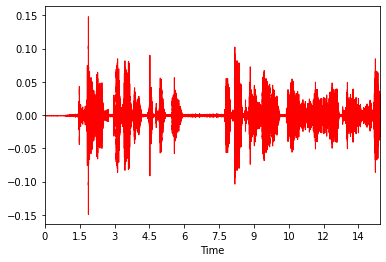

In [16]:
import librosa.display
librosa.display.waveplot(test, sr=sr, color='r')

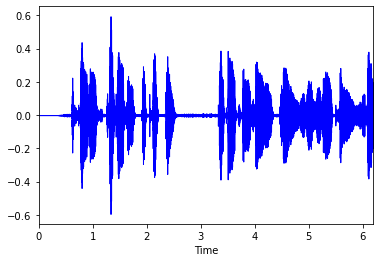

In [26]:
y, sr = librosa.load("./test.wav")
fft = np.fft.fft(y)
#test = librosa.feature.inverse.mfcc_to_audio(mfcc_test)
import soundfile as sf
sf.write('output1.wav', test, sr, subtype='PCM_24')
librosa.display.waveplot(y, sr=sr, color='b')

(136704,)


Text(0.5, 1.0, 'Power spectrum')

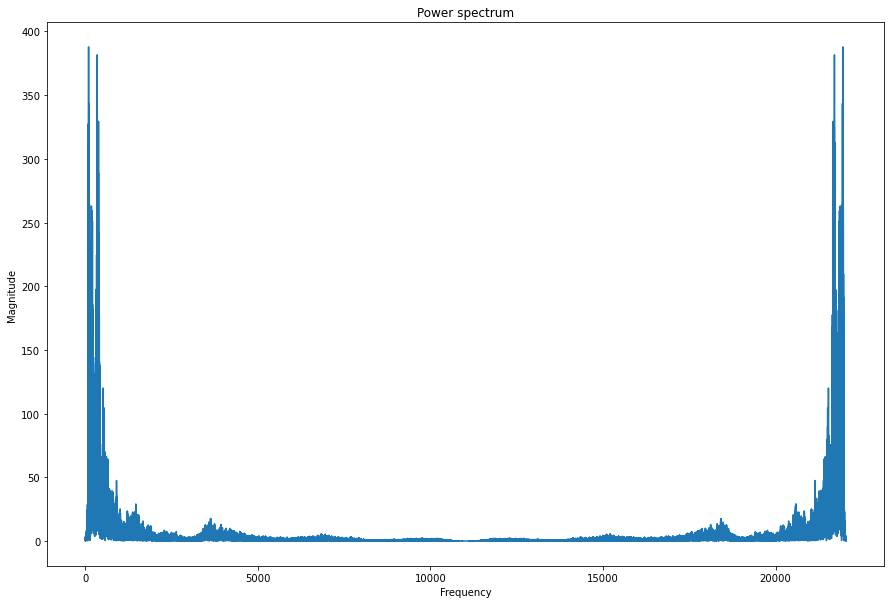

In [32]:
magnitude = np.abs(fft)
print(magnitude.shape)
f = np.linspace(0, sr, len(magnitude))

left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
plt.plot(f, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")